In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from seq_diff import diff_html

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/transcriptase/train_cut.npz', allow_pickle = True) as data:
    X = data['parents']
    Y = data['children']
    V = data['vocab_index'].tolist()

In [4]:
V

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'X': 20,
 'Y': 21,
 'Z': 22}

In [5]:
model = keras.models.load_model("./models/transcriptase_6_atmesta")
model

2022-09-13 10:43:11.151260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2022-09-13 10:43:11.163566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:43:11.163718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 10:43:11.164369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 10:43:11.165134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
token_index = V
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]
legit_values = [decoded_x.startswith('PISP') and decoded_y.startswith('PISP')   for decoded_x, decoded_y  in zip(decode_seq(X), decode_seq(Y))]

# New heading

In [7]:
i = 2
x1 = decode_seq(X[i:i+1,:,:])[0]
y1 = decode_seq(Y[i:i+1,:,:])[0]
_ = diff_html(x1, y1, display_a=True, display_b=True)

In [8]:
np.where(np.array(legit_values)==False)

(array([    0,     1,     2, ..., 17197, 17198, 17207]),)

In [9]:
yp1 = decode_seq(model.predict([ X[i:i+1,:,:], np.array([0.01])]))[0]

_ = diff_html(x1, yp1, display_a=True, display_b=True)

1/1 [==============================] - 1s 630ms/step


In [10]:
cce = tf.keras.losses.CategoricalCrossentropy()


In [11]:
cce(np.array(X[legit_values], dtype=np.float32),np.array(Y[legit_values], dtype=np.float32))

2022-09-13 10:43:16.140127: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 293003440 exceeds 10% of free system memory.
2022-09-13 10:43:16.288357: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 293003440 exceeds 10% of free system memory.


<tf.Tensor: shape=(), dtype=float32, numpy=0.52692205>

In [12]:
ce_0 = 0.52692205

In [13]:
X = X[legit_values]
Y = Y[legit_values]

In [14]:
rand_rates = []
for r in tqdm(np.arange(0.00, 1, 0.05)):
    tf.keras.backend.clear_session()
    Y_pred = model.predict([X, np.full((len(X)), r)])
    cc = keras.losses.CategoricalCrossentropy()(X, Y_pred).numpy()
    rand_rates.append([r, cc])
rand_rates = np.array(rand_rates)

  0%|          | 0/20 [00:00<?, ?it/s]

2022-09-13 10:43:16.530161: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 146501720 exceeds 10% of free system memory.
2022-09-13 10:43:16.617507: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 146501720 exceeds 10% of free system memory.


422/422 [==============================] - 2s 3ms/step


2022-09-13 10:43:18.373722: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 293003440 exceeds 10% of free system memory.


422/422 [==============================] - 1s 3ms/step


In [15]:
from scipy.optimize import curve_fit
func = lambda t, a, b, c, d: a * t**3 + b * t**2 + c * t + d
p, _ = curve_fit(func, rand_rates[:,0],  rand_rates[:,1])

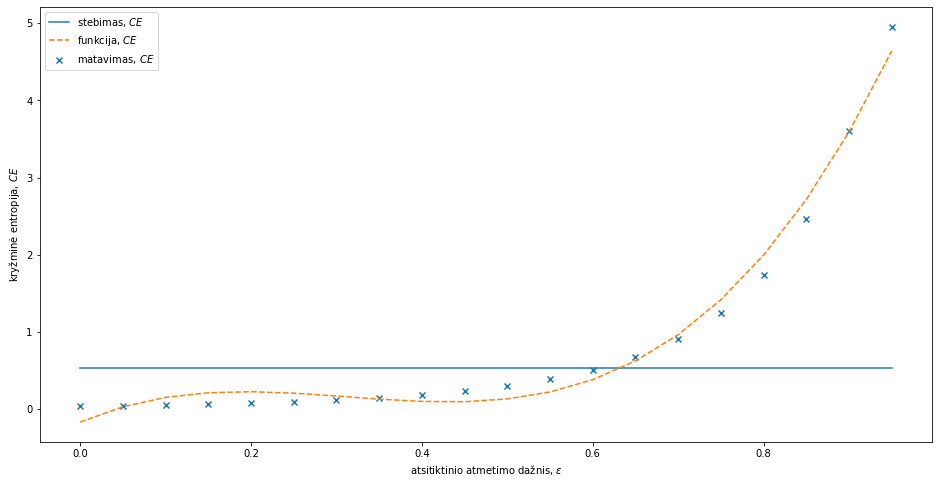

In [16]:
plt.plot(rand_rates[:,0], np.full_like(rand_rates[:,1], ce_0), label="stebimas, $CE$")
plt.plot(rand_rates[:,0], func(rand_rates[:,0], p[0], p[1], p[2], p[3]), '--', label="funkcija, $CE$")
plt.scatter(rand_rates[:,0], rand_rates[:,1], marker='x', label="matavimas, $CE$")
plt.ylabel('kryžminė entropija, $CE$')
plt.xlabel('atsitiktinio atmetimo dažnis, $ε$')

plt.legend()
plt.show()

In [17]:
p, _ = curve_fit(func, rand_rates[:,1],  rand_rates[:,0])
epsilon = func(ce_0, p[0], p[1], p[2], p[3])
print([f'{j:0.5f}' for i,j in enumerate(p)])
epsilon

['0.03924', '-0.34501', '0.91401', '0.14728']


0.5388441350856432

In [18]:
Y_pred = model.predict([ X, np.full(X.shape[0],0)], verbose=0)

In [19]:
X_data = X.astype(np.float32)

In [20]:
Y_data = Y.astype(np.float32)

In [21]:
keras.losses.CategoricalCrossentropy()(X_data, Y_data).numpy()

0.52692205

In [22]:
keras.losses.CategoricalCrossentropy()(X_data, Y_pred).numpy()

0.039280012

In [23]:
keras.losses.CategoricalCrossentropy()(Y_data, Y_pred).numpy()

0.15774417

In [24]:
cce = []
for i in tqdm(range(len(X_data))):
    cce.append([
        keras.losses.CategoricalCrossentropy()(X_data[i:i + 1], Y_data[i:i + 1]).numpy(),
        keras.losses.CategoricalCrossentropy()(X_data[i:i + 1], Y_pred[i:i + 1]).numpy(),
        keras.losses.CategoricalCrossentropy()(Y_data[i:i + 1], Y_pred[i:i + 1]).numpy()
    ])
cce = np.array(cce)


  0%|          | 0/13495 [00:00<?, ?it/s]

In [25]:


plot_names = [
    "X seka - Y stebima seka",
    "X seka - Y sugeneruota seka",
    "Y stebima seka - Y sugeneruota seka"
]



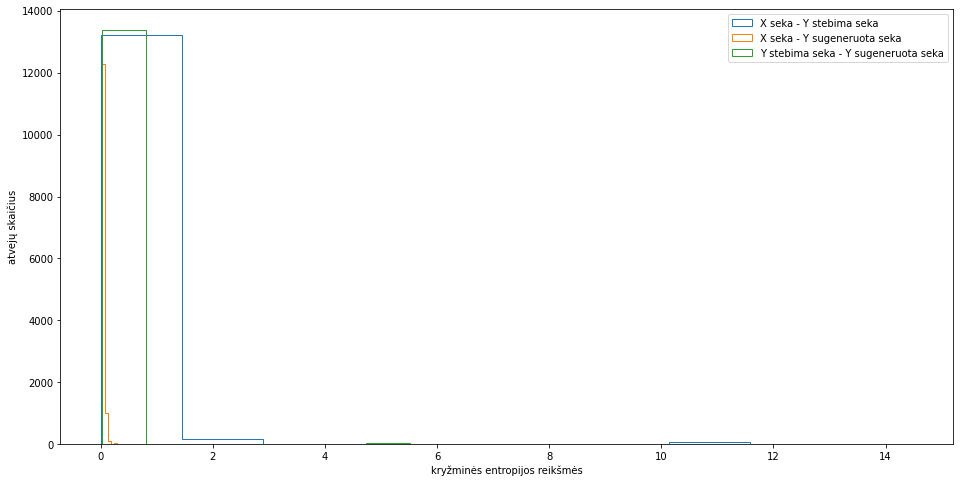

In [26]:
for i, n in enumerate(plot_names):
    plt.hist(cce[:,i], fill=False, bins = 10, histtype='step', label=n)
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [27]:
X_secs = decode_seq(X_data)
Y_secs = decode_seq(Y_data)
Y_pred_secs = decode_seq(Y_pred)

In [28]:
lev_distances = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    lev_distances.append([ 
        distance(x,y), distance(x,p), distance(y,p)
    ])
lev_distances = np.array(lev_distances)

  0%|          | 0/13495 [00:00<?, ?it/s]

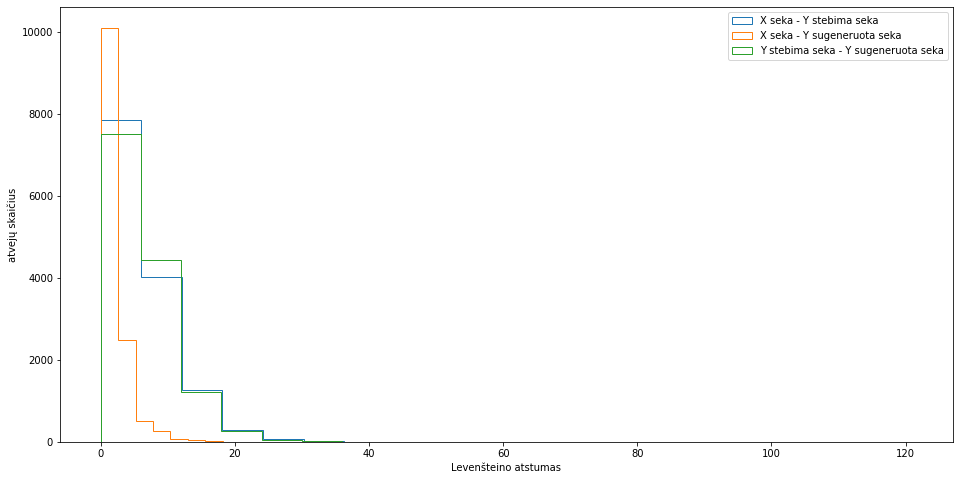

In [29]:
for i, n in enumerate(plot_names):
    plt.hist(lev_distances[:,i], fill=False, bins = 20, density=False, histtype='step', label=n)
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [30]:


lev_ratio = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    lev_ratio.append([ 
        ratio(x,y), ratio(x,p), ratio(y,p)
    ])
lev_ratio = np.array(lev_ratio)



  0%|          | 0/13495 [00:00<?, ?it/s]

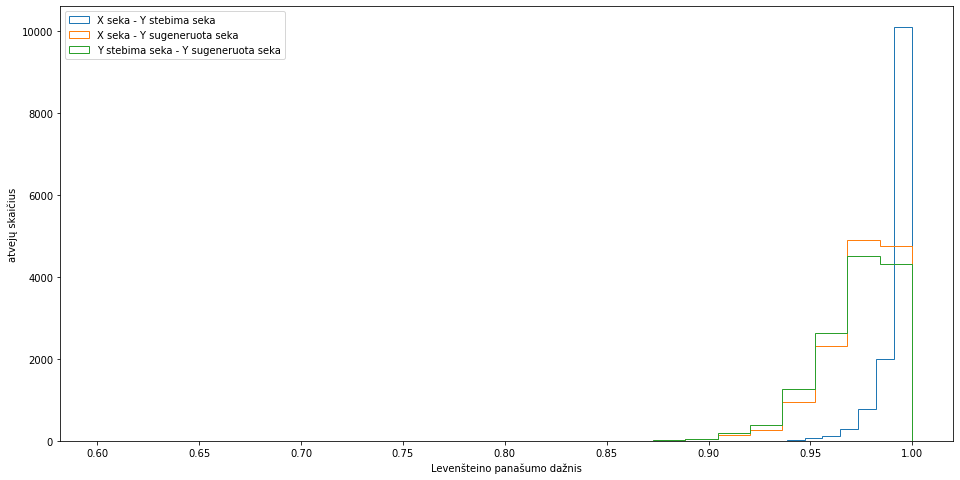

In [31]:
plt.hist(lev_ratio[:,1], fill=False, bins = 25, histtype='step', label="X seka - Y stebima seka")
plt.hist(lev_ratio[:,2], fill=False, bins = 25, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(lev_ratio[:,0], fill=False, bins = 25, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [32]:
ham_distances = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    ham_distances.append([ 
        hamming(x,y), hamming(x,p), hamming(y,p)
    ])
ham_distances = np.array(ham_distances)

  0%|          | 0/13495 [00:00<?, ?it/s]

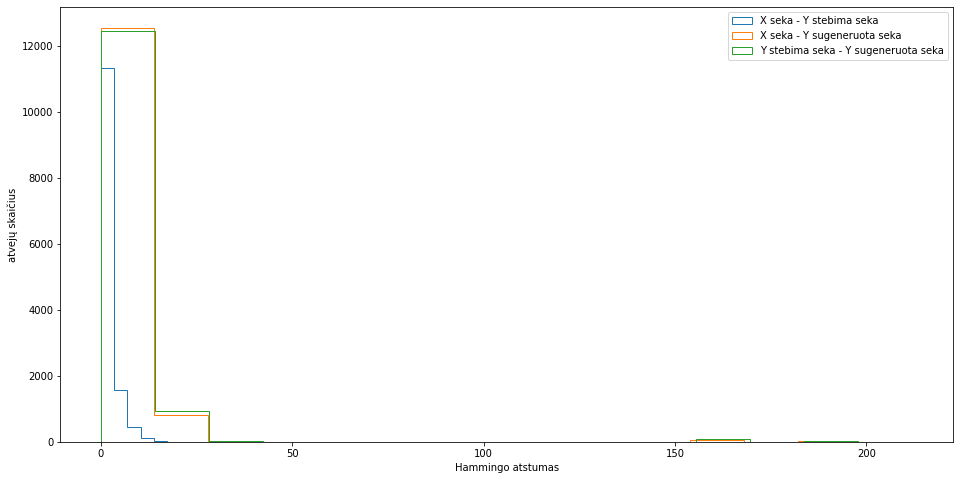

In [33]:


plt.hist(ham_distances[:,1], fill=False, bins = 15, histtype='step', label="X seka - Y stebima seka")
plt.hist(ham_distances[:,2], fill=False, bins = 15, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(ham_distances[:,0], fill=False, bins = 15, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('Hammingo atstumas')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()



# Mutations

In [34]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [35]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_pred, axis = 2)
    ) != 0.0).astype(int), axis = 0)

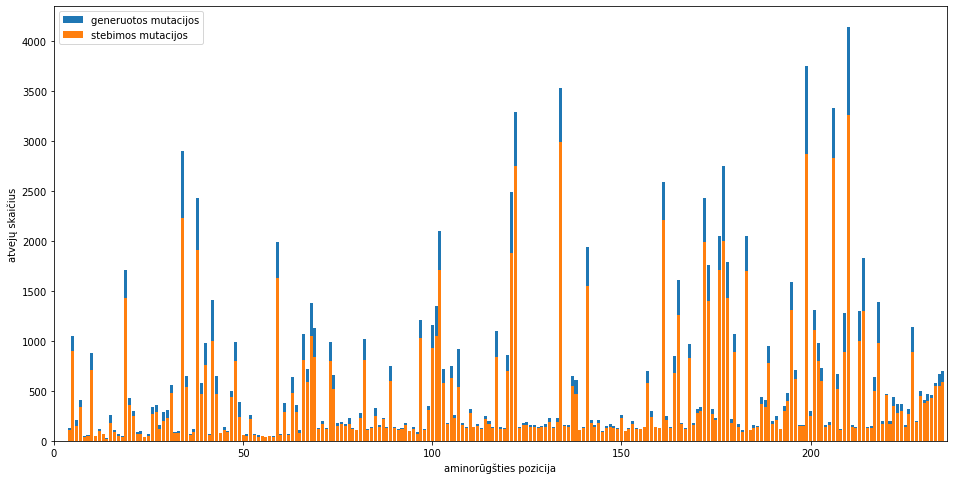

In [36]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut01))
plt.xlabel('aminorūgšties pozicija')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

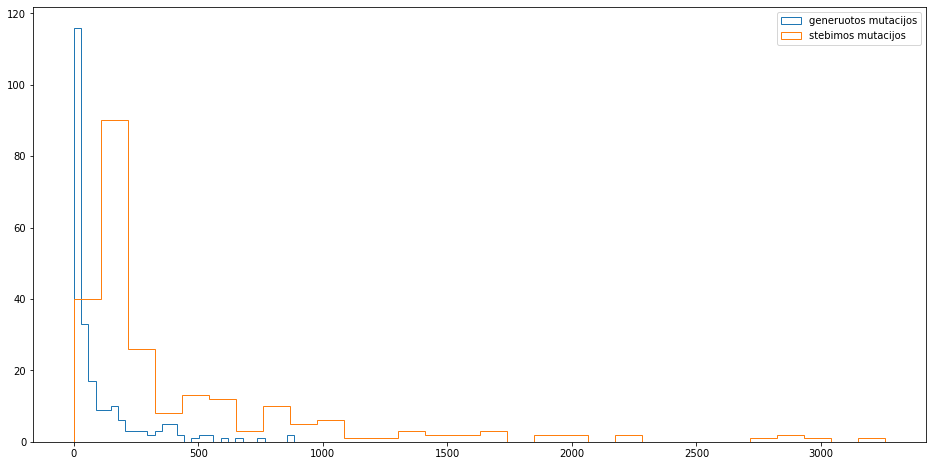

In [37]:
plt.hist(mut02, bins = 30, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 30, label = 'stebimos mutacijos', fill = False, histtype='step')

plt.legend()
plt.show()

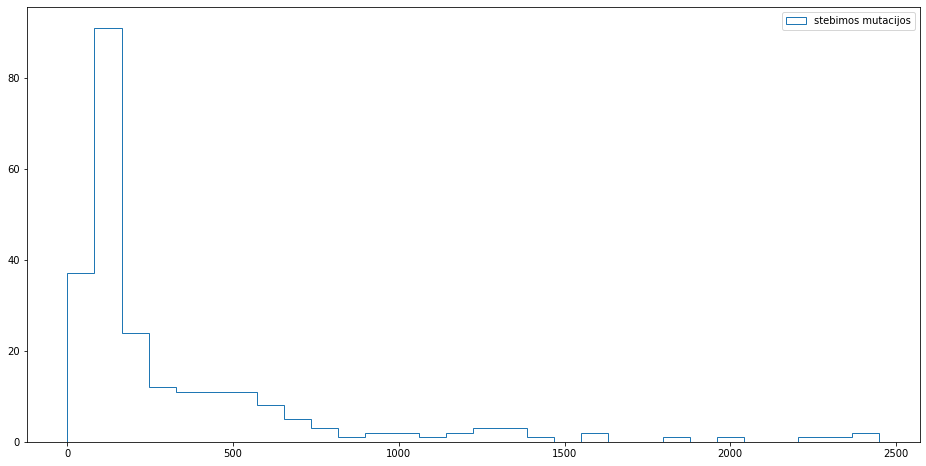

In [38]:
plt.hist(abs(mut02 - mut01), bins = 30, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()

# Siblings

In [39]:
Y_pred_sibs = []
for i in tqdm(range(10)):
    y_ = model.predict([ X_data, np.full((len(X_data)), epsilon)])
    Y_pred_sibs.append([])
    for j in range(len(y_)):
        Y_pred_sibs[i].append(
            keras.losses.CategoricalCrossentropy()(X_data[j:j + 1], y_[j:j + 1]).numpy()
        )
Y_pred_sibs = np.array(Y_pred_sibs)

  0%|          | 0/10 [00:00<?, ?it/s]

422/422 [==============================] - 1s 3ms/step


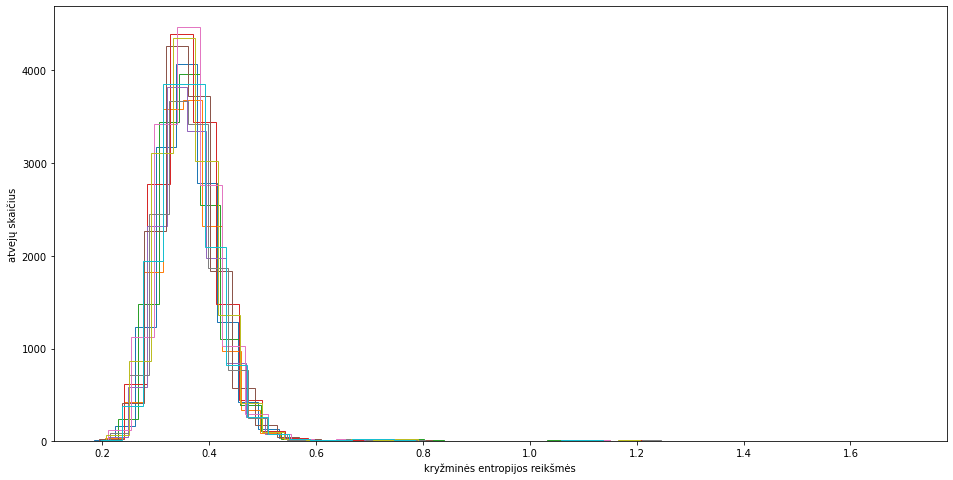

In [40]:
for i in range(len(Y_pred_sibs)):
    plt.hist(Y_pred_sibs[i], fill=False, bins = 35, histtype='step')
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()

In [41]:
i = 2
n = 100


In [42]:
Y_pred_sibs = []
for i in tqdm(range(n)):
    y_ = model.predict([ X_data[i:i+1], np.full((1), epsilon)])
    Y_pred_sibs.append(y_[0])
Y_pred_sibs = np.array(Y_pred_sibs)


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


In [43]:
mut03 = np.sum(
    (np.subtract(
        np.repeat(np.argmax(X_data[i:i+1], axis = 2), n, axis=0), 
        np.argmax(Y_pred_sibs, axis = 2)
    ) != 0.0).astype(int), axis = 0)


In [44]:
mut04 = np.sum(
    (np.subtract(
        np.argmax(X_data[i:i+1], axis = 2), 
        np.argmax(Y_data[i:i+1], axis = 2)
    ) != 0.0).astype(int), axis = 0)


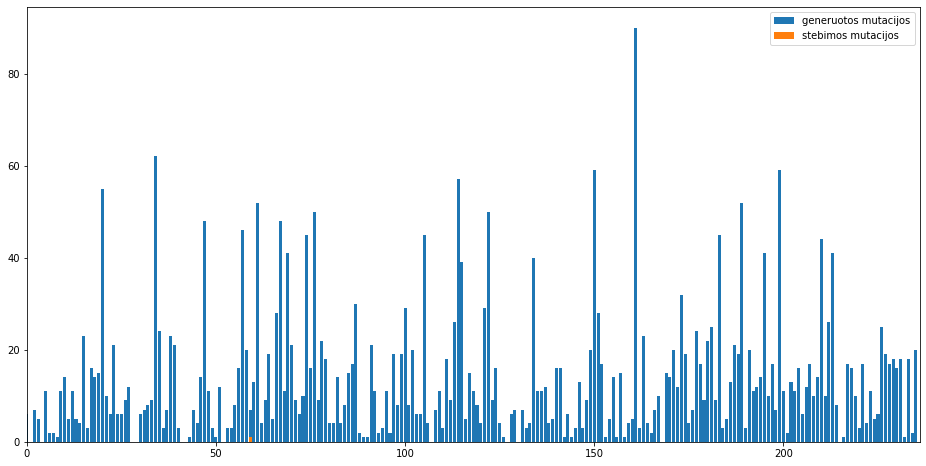

In [45]:
x_range = list(range(len(mut03)))
plt.bar(x_range, mut03, bottom=mut04, label = 'generuotos mutacijos')
plt.bar(x_range, mut04, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut03))
plt.legend()
plt.show()


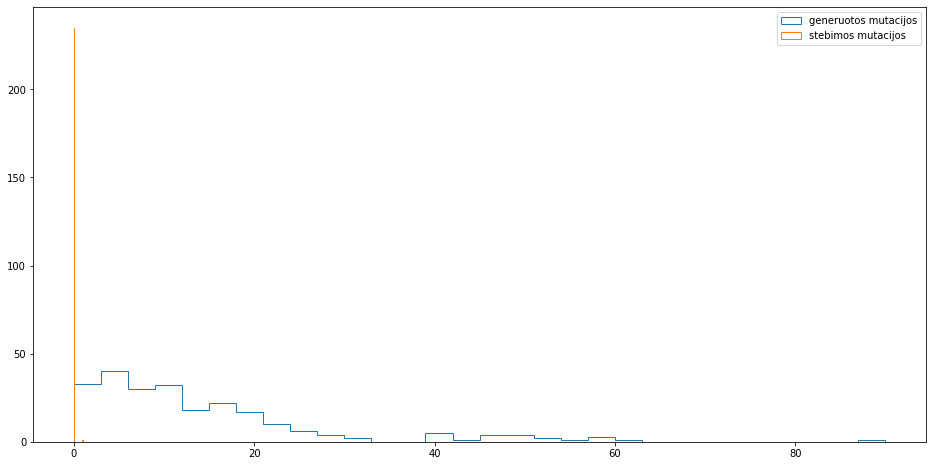

In [46]:
plt.hist(mut03, bins = 30, label = 'generuotos mutacijos', fill = False, histtype='step')
_ = plt.hist(mut04, bins = 30, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()


In [47]:
i = 5
x1 = decode_seq(X_data[i:i+1,:,:])[0]
y1 = decode_seq(Y_data[i:i+1,:,:])[0]

_ = diff_html(x1, y1, display_a=True, display_b=True)
